In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [15]:
class DeFiCreditScorer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        self.feature_names = []

    def load_data(self, json_file_path):
        """Load transaction data from JSON file"""
        with open(json_file_path, 'r') as f:
            data = json.load(f)
        return pd.DataFrame(data)

    def engineer_features(self, df):
        """Engineer features from raw transaction data"""
        # Convert timestamp to datetime
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

        # Extract action data fields
        df['amount'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)))
        df['asset_symbol'] = df['actionData'].apply(lambda x: x.get('assetSymbol', ''))
        df['asset_price_usd'] = df['actionData'].apply(lambda x: float(x.get('assetPriceUSD', 0)))
        df['usd_value'] = df['amount'] * df['asset_price_usd']

        # Group by wallet for feature engineering
        wallet_features = []

        for wallet in df['userWallet'].unique():
            wallet_df = df[df['userWallet'] == wallet].copy()
            wallet_df = wallet_df.sort_values('timestamp')

            features = self._calculate_wallet_features(wallet_df)
            features['userWallet'] = wallet
            wallet_features.append(features)

        return pd.DataFrame(wallet_features)

    def _calculate_wallet_features(self, wallet_df):
        """Calculate features for a single wallet"""
        features = {}

        # Basic activity metrics
        features['total_transactions'] = len(wallet_df)
        features['unique_actions'] = wallet_df['action'].nunique()
        features['total_volume_usd'] = wallet_df['usd_value'].sum()
        features['avg_transaction_size'] = wallet_df['usd_value'].mean()
        features['median_transaction_size'] = wallet_df['usd_value'].median()

        # Time-based features
        if len(wallet_df) > 1:
            time_diff = wallet_df['datetime'].max() - wallet_df['datetime'].min()
            features['activity_duration_days'] = time_diff.total_seconds() / (24 * 3600)
            features['avg_time_between_tx'] = time_diff.total_seconds() / len(wallet_df)
        else:
            features['activity_duration_days'] = 0
            features['avg_time_between_tx'] = 0

        # Action distribution
        action_counts = wallet_df['action'].value_counts()
        total_actions = len(wallet_df)

        features['deposit_ratio'] = action_counts.get('deposit', 0) / total_actions
        features['borrow_ratio'] = action_counts.get('borrow', 0) / total_actions
        features['repay_ratio'] = action_counts.get('repay', 0) / total_actions
        features['redeem_ratio'] = action_counts.get('redeemunderlying', 0) / total_actions
        features['liquidation_ratio'] = action_counts.get('liquidationcall', 0) / total_actions

        # Behavioral indicators
        features['is_balanced_user'] = int(features['deposit_ratio'] > 0.3 and features['borrow_ratio'] > 0.1)
        features['is_lender_only'] = int(features['deposit_ratio'] > 0.8 and features['borrow_ratio'] == 0)
        features['high_liquidation_risk'] = int(features['liquidation_ratio'] > 0.1)

        # Asset diversification
        features['unique_assets'] = wallet_df['asset_symbol'].nunique()
        features['asset_diversity_score'] = features['unique_assets'] / max(features['total_transactions'], 1)

        # Risk metrics
        features['max_single_tx_usd'] = wallet_df['usd_value'].max()
        features['transaction_size_volatility'] = wallet_df['usd_value'].std()
        features['volume_concentration'] = features['max_single_tx_usd'] / features['total_volume_usd'] if features['total_volume_usd'] > 0 else 0

        # Consistency metrics
        if len(wallet_df) > 1:
            features['transaction_regularity'] = self._calculate_regularity(wallet_df['datetime'])
        else:
            features['transaction_regularity'] = 0

        # Bot detection features
        features['potential_bot_score'] = self._calculate_bot_score(wallet_df)

        return features

    def _calculate_regularity(self, timestamps):
        """Calculate transaction regularity (lower values = more regular)"""
        if len(timestamps) < 3:
            return 0

        time_diffs = timestamps.diff().dropna()
        if len(time_diffs) == 0:
            return 0

        time_diffs_seconds = time_diffs.dt.total_seconds()
        cv = time_diffs_seconds.std() / time_diffs_seconds.mean() if time_diffs_seconds.mean() > 0 else 0
        return min(cv, 10)  # Cap at 10 for normalization

    def _calculate_bot_score(self, wallet_df):
        """Calculate bot-like behavior score (0-1, higher = more bot-like)"""
        bot_indicators = 0

        # Very regular timing
        if len(wallet_df) > 3:
            regularity = self._calculate_regularity(wallet_df['datetime'])
            if regularity < 0.1:  # Very regular
                bot_indicators += 0.3

        # Repetitive amounts
        if len(wallet_df) > 2:
            unique_amounts = wallet_df['usd_value'].nunique()
            if unique_amounts / len(wallet_df) < 0.3:
                bot_indicators += 0.2

        # High transaction frequency
        if len(wallet_df) > 1:
            time_span = (wallet_df['datetime'].max() - wallet_df['datetime'].min()).total_seconds()
            if time_span > 0:
                tx_per_hour = len(wallet_df) / (time_span / 3600)
                if tx_per_hour > 5:
                    bot_indicators += 0.3

        # Limited action diversity
        if wallet_df['action'].nunique() == 1:
            bot_indicators += 0.2

        return min(bot_indicators, 1.0)

    def create_target_score(self, features_df):
        """Create synthetic target scores for training (in real scenario, use labeled data)"""
        scores = []

        for _, row in features_df.iterrows():
            base_score = 500  # Start with neutral score

            # Positive factors
            if row['is_balanced_user']:
                base_score += 150
            if row['total_transactions'] > 10:
                base_score += 100
            if row['asset_diversity_score'] > 0.3:
                base_score += 100
            if row['activity_duration_days'] > 30:
                base_score += 100
            if row['repay_ratio'] > 0.1:
                base_score += 100

            # Negative factors
            if row['high_liquidation_risk']:
                base_score -= 200
            if row['potential_bot_score'] > 0.5:
                base_score -= 150
            if row['volume_concentration'] > 0.8:
                base_score -= 100
            if row['transaction_size_volatility'] > row['avg_transaction_size'] * 5:
                base_score -= 100

            # Normalize volume impact
            volume_factor = min(np.log10(row['total_volume_usd'] + 1) * 20, 100)
            base_score += volume_factor

            # Add some randomness for training
            base_score += np.random.normal(0, 50)

            scores.append(max(0, min(1000, base_score)))

        return np.array(scores)

    def train_model(self, features_df, target_scores):
        """Train the credit scoring model"""
        # Select features for training
        feature_columns = [col for col in features_df.columns if col != 'userWallet']
        X = features_df[feature_columns]
        y = target_scores

        # Handle missing values
        X = X.fillna(0)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train model
        self.model.fit(X_train_scaled, y_train)
        self.feature_names = feature_columns

        # Evaluate
        y_pred = self.model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        print(f"Model Performance:")
        print(f"RMSE: {rmse:.2f}")
        print(f"R² Score: {r2:.3f}")

        return {
            'rmse': rmse,
            'r2_score': r2,
            'feature_importance': dict(zip(feature_columns, self.model.feature_importances_))
        }

    def predict_scores(self, features_df):
        """Predict credit scores for wallets"""
        X = features_df[self.feature_names].fillna(0)
        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)

        # Ensure scores are in 0-1000 range
        predictions = np.clip(predictions, 0, 1000)

        return predictions

    def generate_score_report(self, features_df, scores):
        """Generate detailed scoring report"""
        report = []

        for i, (_, row) in enumerate(features_df.iterrows()):
            wallet_report = {
                'userWallet': row['userWallet'],
                'credit_score': int(scores[i]),
                'score_tier': self._get_score_tier(scores[i]),
                'key_metrics': {
                    'total_transactions': int(row['total_transactions']),
                    'total_volume_usd': round(row['total_volume_usd'], 2),
                    'activity_duration_days': round(row['activity_duration_days'], 1),
                    'unique_assets': int(row['unique_assets']),
                    'bot_score': round(row['potential_bot_score'], 3)
                },
                'risk_factors': self._identify_risk_factors(row),
                'positive_factors': self._identify_positive_factors(row)
            }
            report.append(wallet_report)

        return sorted(report, key=lambda x: x['credit_score'], reverse=True)

    def _get_score_tier(self, score):
        """Convert numeric score to tier"""
        if score >= 800:
            return "Excellent"
        elif score >= 700:
            return "Good"
        elif score >= 600:
            return "Fair"
        elif score >= 500:
            return "Poor"
        else:
            return "Very Poor"

    def _identify_risk_factors(self, row):
        """Identify risk factors for a wallet"""
        risks = []

        if row['high_liquidation_risk']:
            risks.append("High liquidation activity")
        if row['potential_bot_score'] > 0.5:
            risks.append("Bot-like behavior detected")
        if row['volume_concentration'] > 0.7:
            risks.append("High volume concentration")
        if row['liquidation_ratio'] > 0.05:
            risks.append("Liquidation events present")
        if row['transaction_size_volatility'] > row['avg_transaction_size'] * 3:
            risks.append("High transaction size volatility")

        return risks

    def _identify_positive_factors(self, row):
        """Identify positive factors for a wallet"""
        positives = []

        if row['is_balanced_user']:
            positives.append("Balanced lending/borrowing activity")
        if row['repay_ratio'] > 0.1:
            positives.append("Regular repayment behavior")
        if row['asset_diversity_score'] > 0.3:
            positives.append("Good asset diversification")
        if row['activity_duration_days'] > 30:
            positives.append("Long-term protocol usage")
        if row['total_transactions'] > 20:
            positives.append("High engagement level")

        return positives
def main():
    """Main execution function"""
    # Initialize scorer
    scorer = DeFiCreditScorer()

    # Load data (replace with your JSON file path)
    json_file = "/content/user-wallet-transactions.json"  # Update this path

    try:
        print("Loading transaction data...")
        df = scorer.load_data(json_file)
        print(f"Loaded {len(df)} transactions for {df['userWallet'].nunique()} wallets")

        # Engineer features
        print("Engineering features...")
        features_df = scorer.engineer_features(df)
        print(f"Generated {len(features_df.columns)-1} features for {len(features_df)} wallets")

        # Create target scores for training (in production, use real labeled data)
        print("Creating target scores for training...")
        target_scores = scorer.create_target_score(features_df)

        # Train model
        print("Training credit scoring model...")
        model_metrics = scorer.train_model(features_df, target_scores)

        # Generate predictions
        print("Generating credit scores...")
        predicted_scores = scorer.predict_scores(features_df)

        # Generate report
        print("Creating score report...")
        score_report = scorer.generate_score_report(features_df, predicted_scores)

        # Display results
        print("\n" + "="*60)
        print("CREDIT SCORE REPORT")
        print("="*60)

        for wallet_info in score_report[:10]:  # Show top 10
            print(f"\nWallet: {wallet_info['userWallet']}")
            print(f"Credit Score: {wallet_info['credit_score']} ({wallet_info['score_tier']})")
            print(f"Transactions: {wallet_info['key_metrics']['total_transactions']}")
            print(f"Volume: ${wallet_info['key_metrics']['total_volume_usd']:,.2f}")
            print(f"Bot Score: {wallet_info['key_metrics']['bot_score']}")

            if wallet_info['positive_factors']:
                print(f"Strengths: {', '.join(wallet_info['positive_factors'])}")
            if wallet_info['risk_factors']:
                print(f"Risks: {', '.join(wallet_info['risk_factors'])}")

        print(f"\nFeature Importance (Top 10):")
        sorted_features = sorted(model_metrics['feature_importance'].items(),
                               key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_features[:10]:
            print(f"  {feature}: {importance:.3f}")

        # Save results
        output_file = "credit_scores.json"
        with open(output_file, 'w') as f:
            json.dump(score_report, f, indent=2)
        print(f"\nResults saved to {output_file}")

    except FileNotFoundError:
        print(f"Error: Could not find {json_file}")
        print("Please ensure the JSON file exists in the current directory")
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()


Loading transaction data...
Loaded 100000 transactions for 3497 wallets
Engineering features...
Generated 22 features for 3497 wallets
Creating target scores for training...
Training credit scoring model...
Model Performance:
RMSE: 54.75
R² Score: 0.863
Generating credit scores...
Creating score report...

CREDIT SCORE REPORT

Wallet: 0x00010a708585ba4812a1c5976182626c75cb7a6b
Credit Score: 998 (Excellent)
Transactions: 29
Volume: $1,770,176,221,970,117,689,344.00
Bot Score: 0.0
Strengths: Balanced lending/borrowing activity, Regular repayment behavior, Long-term protocol usage, High engagement level

Wallet: 0x002de04d579930686698abab5f48bda0b24fb9fc
Credit Score: 998 (Excellent)
Transactions: 85
Volume: $78,597,435,576,826,401,390,592.00
Bot Score: 0.0
Strengths: Balanced lending/borrowing activity, Regular repayment behavior, Long-term protocol usage, High engagement level

Wallet: 0x004d71c111862702272e6beccdaafb07c9b96c37
Credit Score: 998 (Excellent)
Transactions: 276
Volume: $11

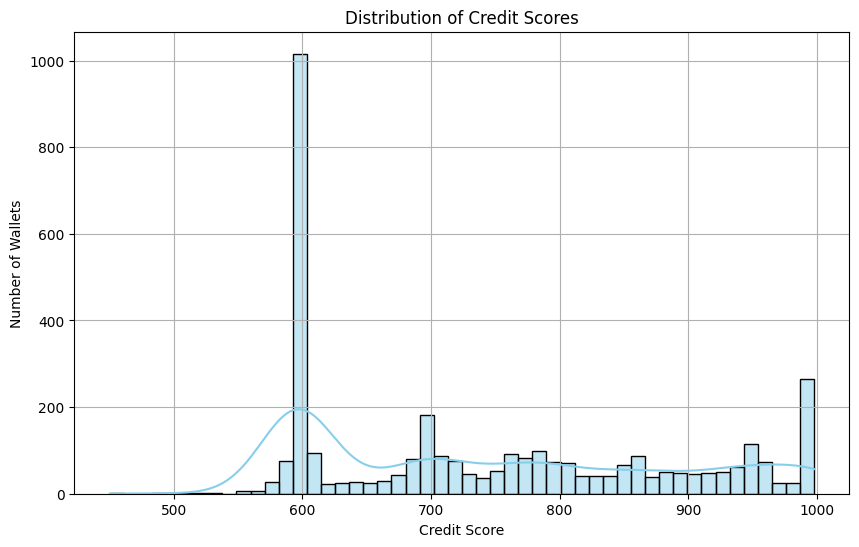

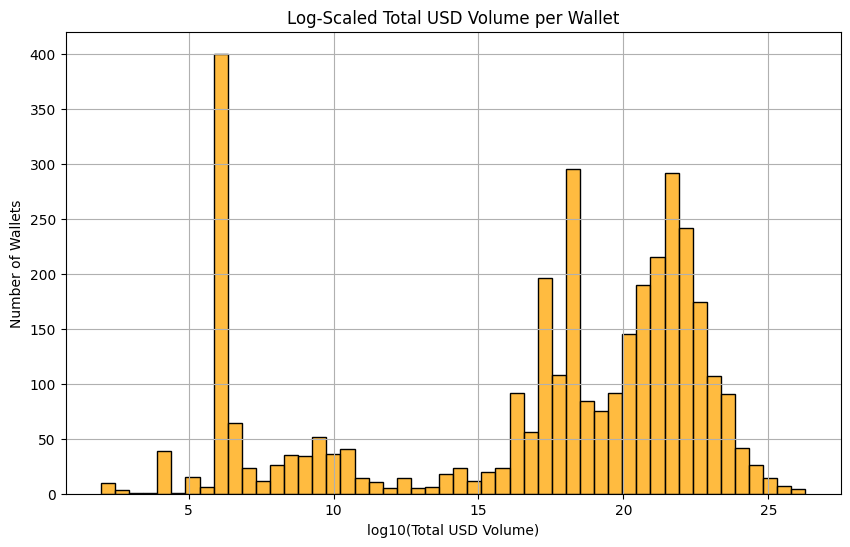

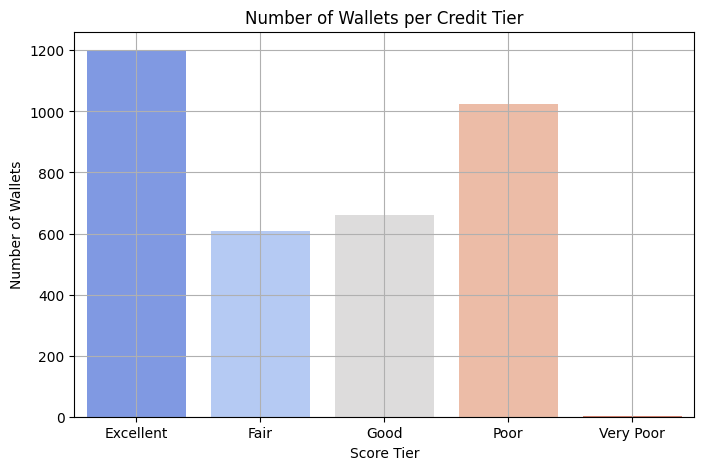

In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load score report
with open("/content/credit_scores.json", "r") as f:
    score_report = json.load(f)

report_df = pd.DataFrame(score_report)

# Flatten nested key metrics
report_df = pd.concat([
    report_df.drop(columns=["key_metrics"]),
    report_df["key_metrics"].apply(pd.Series)
], axis=1)

# 1. Histogram of Credit Scores
plt.figure(figsize=(10,6))
sns.histplot(report_df['credit_score'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()

# 2. Distribution of Total Volume (log-scaled)
report_df['log_volume'] = np.log10(report_df['total_volume_usd'] + 1)
plt.figure(figsize=(10,6))
sns.histplot(report_df['log_volume'], bins=50, color='orange')
plt.title('Log-Scaled Total USD Volume per Wallet')
plt.xlabel('log10(Total USD Volume)')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()

# 3. Tier-wise Wallet Distribution
tier_counts = report_df['score_tier'].value_counts().sort_index()
plt.figure(figsize=(8,5))
sns.barplot(x=tier_counts.index, y=tier_counts.values, palette='coolwarm')
plt.title('Number of Wallets per Credit Tier')
plt.xlabel('Score Tier')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()


In [19]:
!pip install -q plotly

In [20]:
import plotly.express as px

# Interactive Histogram
fig = px.histogram(report_df, x="credit_score", nbins=50, title="Interactive Credit Score Distribution")
fig.show()

# Interactive Scatter
fig2 = px.scatter(report_df, x="log_volume", y="credit_score", hover_data=["userWallet"],
                  title="Credit Score vs Log-Scaled USD Volume")
fig2.show()

# Interactive Pie Chart
fig3 = px.pie(report_df, names='score_tier', title='Wallet Distribution by Credit Tier')
fig3.show()
